In [1]:
from abc import ABC
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# 设置中文字体和负号正常显示
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
# 读取数据
flight_data = pd.read_csv('flights.csv')
flight_data.head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


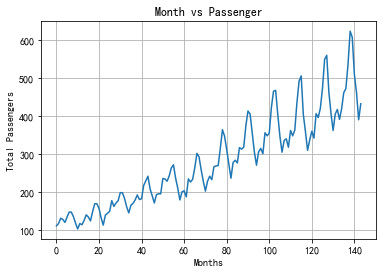

In [3]:
# 数据可视化
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.plot(flight_data['passengers'])

In [4]:
all_data = flight_data['passengers'].values.astype(float)
all_data

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.])

In [5]:
all_data.shape  # 共有144条数据

(144,)

In [6]:
test_data_size = 12
train_data = all_data[:-test_data_size]  # 训练数据集
test_data = all_data[-test_data_size:]  # 测试数据集(最后12条)

In [7]:
from sklearn.preprocessing import MinMaxScaler

# 最大最小值数据缩放
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))
train_data_normalized = torch.from_numpy(train_data_normalized).to(torch.float32)

In [8]:
train_window = 12  # 特征窗口大小为12


def create_inout_sequences(input_data, tw):
    """用前12条数据预测第13条数据"""
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw):
        train_seq = input_data[i:i + tw]
        train_label = input_data[i + tw:i + tw + 1]
        inout_seq.append((train_seq, train_label))
    return inout_seq


train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
train_inout_seq[0]

(tensor([[0.0176],
         [0.0308],
         [0.0615],
         [0.0549],
         [0.0374],
         [0.0681],
         [0.0967],
         [0.0967],
         [0.0703],
         [0.0330],
         [0.0000],
         [0.0308]]),
 tensor([[0.0242]]))

In [9]:
# 定义LSTM模型
class LSTM(nn.Module, ABC):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.reshape(input_seq.shape[0], 1, 1))  # 这里设置不接受上次的记忆h/c
        lstm_out = lstm_out.reshape(lstm_out.size()[0], -1)
        predictions = self.linear(lstm_out)
        return predictions[-1]  # 预测值,这里取最后一个数据的输出


model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [10]:
epochs = 200  # 训练epochs

for j in range(epochs):
    single_loss = 0
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels[0])
        single_loss.backward()
        optimizer.step()

    if (j + 1) % 25 == 0:
        print(f'epoch: {j + 1:3} loss: {single_loss.item():10.8f}')

epoch:  25 loss: 0.00643396
epoch:  50 loss: 0.00153534
epoch:  75 loss: 0.00149411
epoch: 100 loss: 0.00010602
epoch: 125 loss: 0.00027665
epoch: 150 loss: 0.00126756
epoch: 175 loss: 0.00004038
epoch: 200 loss: 0.00013968


In [11]:
# 进行预测的第一组数据
seq = train_data_normalized[-12:]
seq

tensor([[0.5626],
        [0.5231],
        [0.6637],
        [0.6418],
        [0.6945],
        [0.8088],
        [0.9758],
        [1.0000],
        [0.7890],
        [0.6659],
        [0.5670],
        [0.6615]])

In [12]:
for k in range(12):
    # 预测最后12条数据
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        predict = model(seq).reshape(1, 1)
        seq = torch.cat((seq, predict), dim=0)  # 将新预测的点不断添加到seq中

In [ ]:
actual_predictions = scaler.inverse_transform(seq.numpy())  # 预测输出重新转换为实际值
actual_predictions

In [ ]:
actual_predictions[-12:]  # 最后12条数据的预测值

In [ ]:
import numpy as np

step = np.arange(132, 144, 1)

# 查看拟合效果
plt.plot(flight_data['passengers'], label='真实曲线', color='b')
plt.plot(step, actual_predictions[-12:].reshape(12, ), color='red', label='最后10条数据的预测')  # 拟合效果图
plt.legend()
plt.show()